##### Lecture 15: Sensitivity analysis

1. Local sensitivity analysis on the Ishigami function using the base point $\mathbf{x} = [0,0,0]$. Perturb by step size $\Delta x = 0.1$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
def f_ishigami(x):
    return np.sin(x[0]) + 7 * np.sin(x[1])**2 + 0.1 * x[2] ** 4 * np.sin(x[0])

dx = 0.1 # step size to estimate partial derivative
x_base = np.array([0.,0.,0.])

# loop over parameters
for i in range(3):
    x_test = x_base.copy()
    x_test[i] = x_test[i] + dx # perturb i_th parameter
    dfdx = (f_ishigami(x_test) - f_ishigami(x_base)) / dx
    print('Parameter %d, Si = %0.9f' % (i+1, dfdx))

Parameter 1, Si = 0.998334166
Parameter 2, Si = 0.697669776
Parameter 3, Si = 0.000000000


The local sensitivity analysis at this base point indicates that $x_1$ is most sensitive, followed by $x_2$. $x_3$ is not sensitive.

##### Global SA

2. Global sensitivity analysis on the same function, using the SALib package ([Docs](https://salib.readthedocs.io/en/latest/index.html)). The parameter ranges are $[\pi, \pi]$.

In [9]:
# run (uncomment) the next line to install SALib on Google Colab:
# !pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3 
}

In [10]:
# sample parameters and run model
X = saltelli.sample(problem, 1024, calc_second_order=False)
n = X.shape[0]
Y = np.zeros(n)

for i in range(n):
    Y[i] = f_ishigami(X[i,:])

/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_13519/4091823258.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem, 1024, calc_second_order=False)


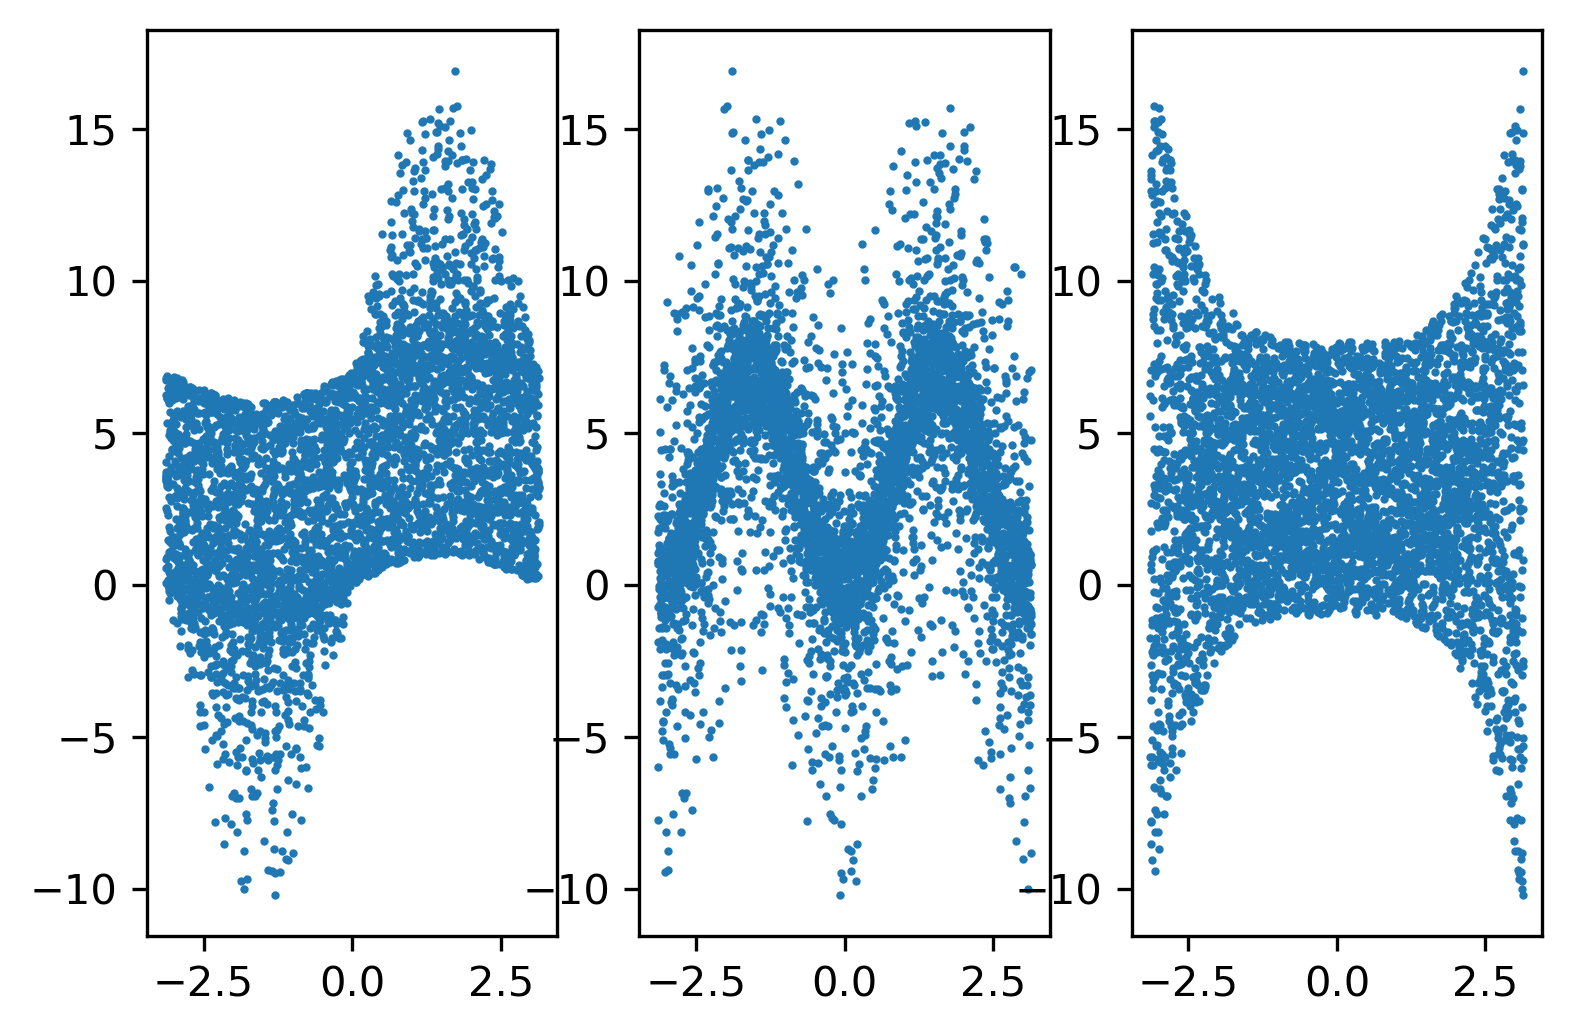

In [11]:
# scatter plot Y vs each parameter
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,i], Y, s=1)
plt.show()

In [12]:
# calculate sensitivity indices
Si = sobol.analyze(problem, Y, print_to_console=True, calc_second_order=False)

          ST   ST_conf
x1  0.555860  0.096209
x2  0.441898  0.034580
x3  0.244675  0.023540
          S1   S1_conf
x1  0.316832  0.058729
x2  0.443763  0.054374
x3  0.012203  0.061221


The return value `Si` is a dictionary with keys `S1`, `S1_conf`, `ST`, and `ST_conf`, which are the first and total-order indices with bootstrap confidence intervals. The `conf` values are the half-width of the 95% CI by default.

This result is different from the local SA because it includes the interaction between $x_1$ and $x_3$. This was not captured in the local SA, which assumes that the influence of each parameter is linearly separable.

-----------

##### Global SA on Lotka-Volterra equations

Predator-prey equations with logistic growth. The steady-state prey population is most sensitive to which parameter(s), $a,b,c,d,K$ ?

$$ \frac{dy_1}{dt} = ay_1(1-\frac{y_1}{K}) - by_1y_2 $$

$$ \frac{dy_2}{dt} = -cy_2 + dy_1y_2$$

- $t$:  time (years), $t \in [0,30]$
- Initial conditions: $y(0) = [2,1]$
- Parameter ranges:
    + $a,b,c,d \in [0.0,1.0]$
    + $K \in [3,20]$


In [13]:
import scipy.integrate

# derivative function - modified from L12
def dydt(t,y,params):
    a,b,c,d,K = params
    return [a*y[0]*(1-y[0]/K) - b*y[0]*y[1], -c*y[1] + d*y[0]*y[1]]

# function to run the model for a given set of parameters x
def f(x):
    sol = scipy.integrate.solve_ivp(dydt, 
                                    t_span=[0, 30], 
                                    y0=[2, 1],
                                    rtol=1e-6,
                                    args=(x,)) # modified from L12
    return sol.y[0,-1] # steady-state prey population


In [15]:
problem = {
  'num_vars': 5,
  'names': ['a', 'b', 'c', 'd', 'K'],
  'bounds': [[0.0, 1.0]]*4 + [[3,20]] 
}

# sample parameters and run model
X = saltelli.sample(problem, 1024, calc_second_order=False)
n = X.shape[0]
Y = np.zeros(n)

# this loop may take time, it's solving the ODE 1024(k+2) ~ 7000 times
for i in range(n):
    if i % 1000 == 0:
        print(i)
    Y[i] = f(X[i,:])

/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_13519/4209628523.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(problem, 1024, calc_second_order=False)


0
1000
2000
3000
4000
5000
6000
7000


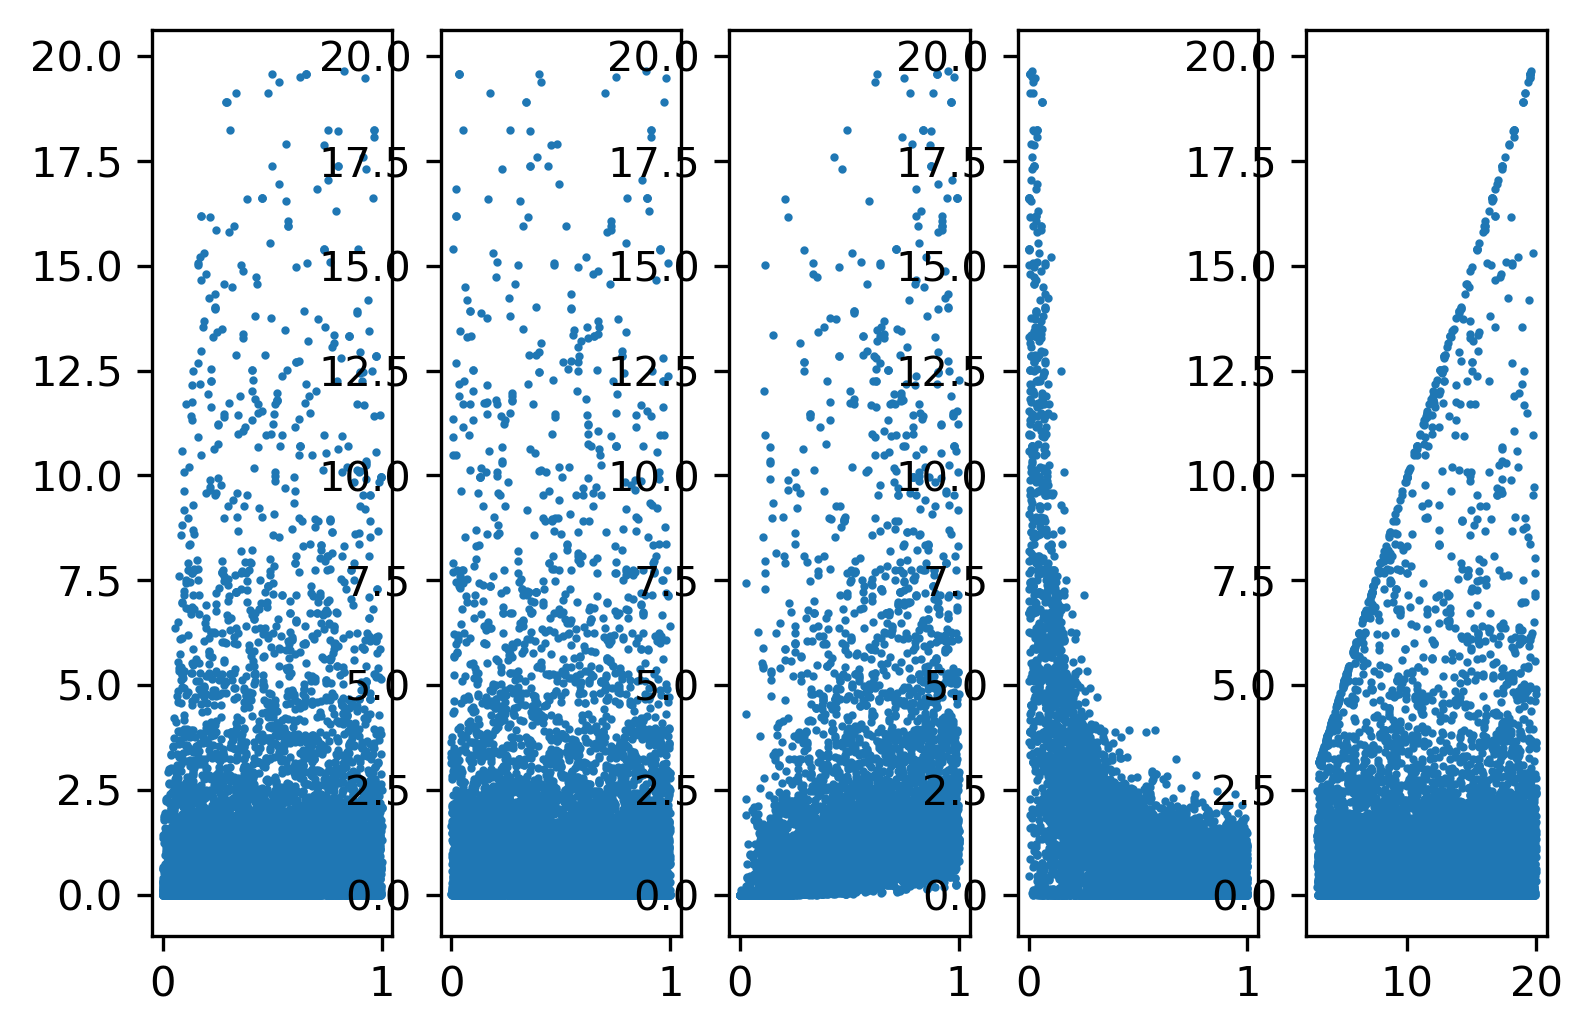

In [16]:
# scatter plot Y vs each parameter
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.scatter(X[:,i], Y, s=1)
plt.show()

In [17]:
# calculate sensitivity indices
Si = sobol.analyze(problem, Y, print_to_console=True, calc_second_order=False)

         ST   ST_conf
a  0.090059  0.036147
b  0.024707  0.009561
c  0.296993  0.084009
d  0.846310  0.142037
K  0.138247  0.051159
         S1   S1_conf
a  0.008257  0.024015
b  0.007569  0.011700
c  0.136449  0.052039
d  0.510976  0.109632
K  0.008447  0.031268


What can we learn from the output?
- The confidence intervals are relatively small compared to the $S_i$ values, which means our sample size is acceptable. We could get narrower CIs by increasing the sample size (currently 1024).
- The most sensitive parameter is $d$, which is the predator growth rate. It accounts for 50% of the variance by itself, and 83% if we include its interactions with other parameters (total-order index)
- Next are the predator death rate $c$ and the prey carrying capacity $K$. These both have interactions with other parameters. We could learn more about these interactions by setting `calc_second_order=True`, which requires 2x the model evaluations.
- Although we are testing the sensitivity of the steady-state prey population, the parameters $a,b$ describing the prey growth and death rates, respectively, are not sensitive.
- These results depend on the parameter ranges we sample.